### **Laboratorio 6 - Deep Learning**
Stefano Aragoni, Carol Arévalo

----------------


#### Análisis Exploratorio de Datos

Sistema de recomendación para libros utilizando el siguiente dataset:

- Books.csv – Datos de 270k libros
- Users.csv – Datos de usuario (id, loca:on, age) (57k usuarios)
- Ratings.csv – Ra:ng 0-10 dado por un usuario a un libro determinado. (340k ra:ngs)

----------------

##### *Importar librerías*

Como primer paso, se importaron las librerías necesarias para el desarrollo del laboratorio.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
from pandas_profiling import ProfileReport

pd.options.display.float_format = '{:.2f}'.format

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_33815/3376000847.py:

-----------

##### *Cargar los Conjuntos de Datos*

Posteriormente, se cargó todos los conjuntos de datos en varios dataframes de pandas.

In [14]:
# Crear un DataFrame con el contenido de Books.csv
df_books = pd.read_csv('./archive/Books.csv')

# Crear un DataFrame con el contenido de Users.csv
df_users = pd.read_csv('./archive/Users.csv')

# Crear un DataFrame con el contenido de Ratings.csv
df_ratings = pd.read_csv('./archive/Ratings.csv')

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_33815/3548937469.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv('./archive/Books.csv')


Posteriormente, se imprimió las primeras 5 filas de cada dataframe para tener una idea de la estructura de los datos.

En el caso del dataframe de Books.csv, se observó 8 columnas. La primera ISBN, que es el identificador único de cada libro, seguido del título, autor, año de publicación, editorial, url de la portada, url de la pequeña portada y la url de la mediana portada.

En este caso, inicialmente se considera que las únicas columnas que serán de utilidad para el sistema de recomendación son el ISBN, título, autor, año de publicación y editorial. Los links de las portadas no serán de utilidad para el sistema de recomendación.

In [15]:
# Convertir variables a tipo numérico
df_books['ISBN'] = df_books['ISBN'].str.replace('X', '10')
df_books['ISBN'] = pd.to_numeric(df_books['ISBN'], errors='coerce')
df_books['Year-Of-Publication'] = pd.to_numeric(df_books['Year-Of-Publication'], errors='coerce')

# Primeras 5 filas de df_books
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,195153448.00,Classical Mythology,Mark P. O. Morford,2002.00,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,2005018.00,Clara Callan,Richard Bruce Wright,2001.00,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,60973129.00,Decision in Normandy,Carlo D'Este,1991.00,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,374157065.00,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.00,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,393045218.00,The Mummies of Urumchi,E. J. W. Barber,1999.00,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [16]:
# Eliminar las columnas Image-URL-S, Image-URL-M, Image-URL-L
df_books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)

Posteriormente, se observó el dataframe de Users.csv. Este contiene 3 columnas; la primera es el identificador único de cada usuario, seguido de la ubicación y la edad. 

Sin embargo, se nota que hay varios usuarios que no tienen edad, por lo que será necesario eliminarlos del dataframe. Asimismo, la columna de Location tiene ciudad,estado y país. Se plantea la posibildiad de únicamente utilizar el país, ya que la ciudad y el estado pueden aumentar la complejidad del sistema de recomendación.

In [17]:
# Convertir variables a tipo numérico
df_users['Age'] = pd.to_numeric(df_users['Age'], errors='coerce')
df_users["User-ID"] = pd.to_numeric(df_users["User-ID"], errors='coerce')

# Primeras 5 filas de df_users
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.00
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.00
4,5,"farnborough, hants, united kingdom",NaN


En el caso de Ratings.csv, se observó que tiene 3 columnas; el identificador único de cada usuario, el ISBN del libro y el rating que le dio el usuario al libro.

Cabe destacar que se considera que todas estas columnas serán de utilidad para el sistema de recomendación.

In [18]:
# Convertir variables a tipo numérico
df_ratings['ISBN'] = df_ratings['ISBN'].str.replace('X', '10')
df_ratings['User-ID'] = pd.to_numeric(df_ratings['User-ID'], errors='coerce')
df_ratings['ISBN'] = pd.to_numeric(df_ratings['ISBN'], errors='coerce')
df_ratings['Book-Rating'] = pd.to_numeric(df_ratings['Book-Rating'], errors='coerce')

# Primeras 5 filas de df_ratings
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,3454510410.00,0
1,276726,155061224.00,5
2,276727,446520802.00,0
3,276729,5216561510.00,3
4,276729,521795028.00,6


-----------

##### *Descripción de Variables*

Como segundo paso del análisis exploratorio, se <font color=orange>obtuvo estadísticas descriptivas básicas de las variables de los conjuntos de datos</font>.

En el caso de df_books, se puede observar que solamente hay dos variables numéricas, que son el año de publicación y el ISBN. El resto de variables son categóricas.

En el caso de estas variables, se puede observar que 50% de los lobros son del año 1995 en adelante. Por alguna razón, hay un libro que tiene el año de publicación 0; se requiere investigar más sobre este libro.

In [19]:
# Estadísticas descriptivas básicas de df_books
df_books.describe()

,ISBN,Year-Of-Publication
count,270832.00,271357.00
mean,1846809906.47,1959.76
std,5482671907.87,257.99
min,913154.00,0.00
25%,394549219.75,1989.00
50%,679847607.00,1995.00
75%,1551660354.75,2000.00
max,99975207010.00,2050.00


En el caso de df_users, se puede observar nuevamente dos variables numéricas, que son el identificador único de cada usuario y la edad. La edad promedio de los usuarios es de 34 años, con una desviación estándar de 14 años. La edad mínima es de 0 años y la máxima es de 244 años. 

Asimismo, cabe destacar que hay varios usuarios que no tienen edad, por lo que se requiere eliminarlos del dataframe.

In [20]:
# Estadísticas descriptivas básicas de df_users
df_users.describe()

,User-ID,Age
count,278858.00,168096.00
mean,139429.50,34.75
std,80499.52,14.43
min,1.00,0.00
25%,69715.25,24.00
50%,139429.50,32.00
75%,209143.75,44.00
max,278858.00,244.00


Finalmente, en df_ratings, se pueden observar tres variables numéricas, que son el identificador único de cada usuario, el ISBN del libro y el rating que le dio el usuario al libro.

En el caso de los ratings, se puede observar que el rating promedio es de 2.87. El 50% de los ratings son 0, por lo cual posiblemente se eliminará una porción de estos ratings para evitar sesgos en el sistema de recomendación.

In [21]:
# Estadísticas descriptivas básicas de df_ratings
df_ratings.describe()

,User-ID,ISBN,Book-Rating
count,1149780.00,1147157.00,1149780.00
mean,140386.40,8805272786311033856.00,2.87
std,80562.28,9430905119786851631104.00,3.85
min,2.00,0.00,0.00
25%,70345.00,380754509.00,0.00
50%,141010.00,553272837.00,0.00
75%,211028.00,872495892.00,7.00
max,278854.00,10101010101010101035859968.00,10.00


-----------

##### *Visualización de Datos*

Como tercer paso, se realizó una <font color=orange>visualización de la distribución de las variables del conjunto de datos</font>.


**DataFrame Books**

Para el caso del dataframe de libros, se realizó un histograma de la distribución de los años de publicación de los libros. Se puede observar que la mayoría de libros fueron publicados en los años 2000 en adelante. 

En el caso de ISBN, se realizó un histograma de la distribución de los ISBN. Se puede observar que la mayoría de libros tienen un ISBN de 0 a 0.15e11. 

array([[<AxesSubplot: title={'center': 'ISBN'}>,
        <AxesSubplot: title={'center': 'Year-Of-Publication'}>]],
      dtype=object)

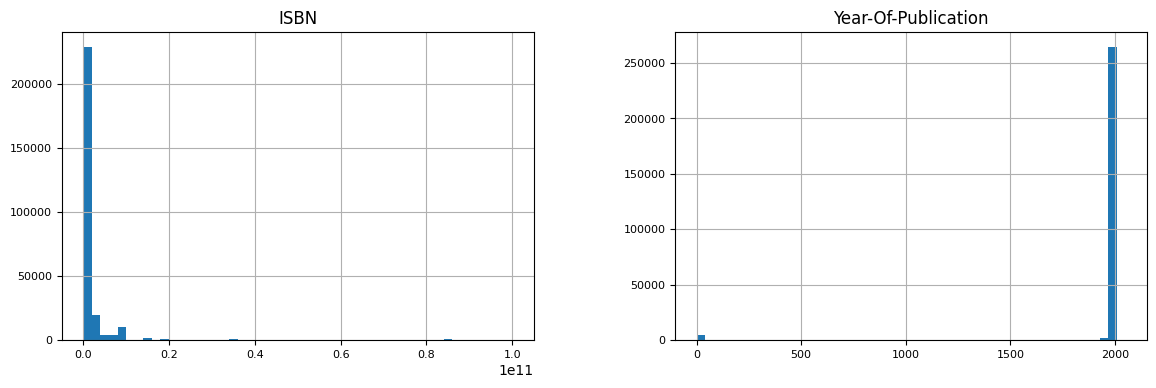

In [26]:
# Visualización de la distribución de las variables de df_books
df_books.hist(figsize=(14, 4), bins=50, xlabelsize=8, ylabelsize=8)

Al analizar el histograma de la distribución de títulos de los libros, se puede observar que hay varios títulos que se repiten; posiblemente a que hay varios libros que son parte de una serie o que son ediciones diferentes del mismo libro.

Con relación a los autores, se puede observar que hay autores con hasta 600 libros publicados. Sin embargo, la mayoría de autores tienen menos de 100 libros publicados.

Finalmente, en el caso de las editoriales, la cada editorial Harlequin tiene más de 7000 libros publicados. El segundo lugar lo tiene Silhouette con más de 4000 libros publicados. El resto de editoriales tienen menos de 2000 libros publicados.

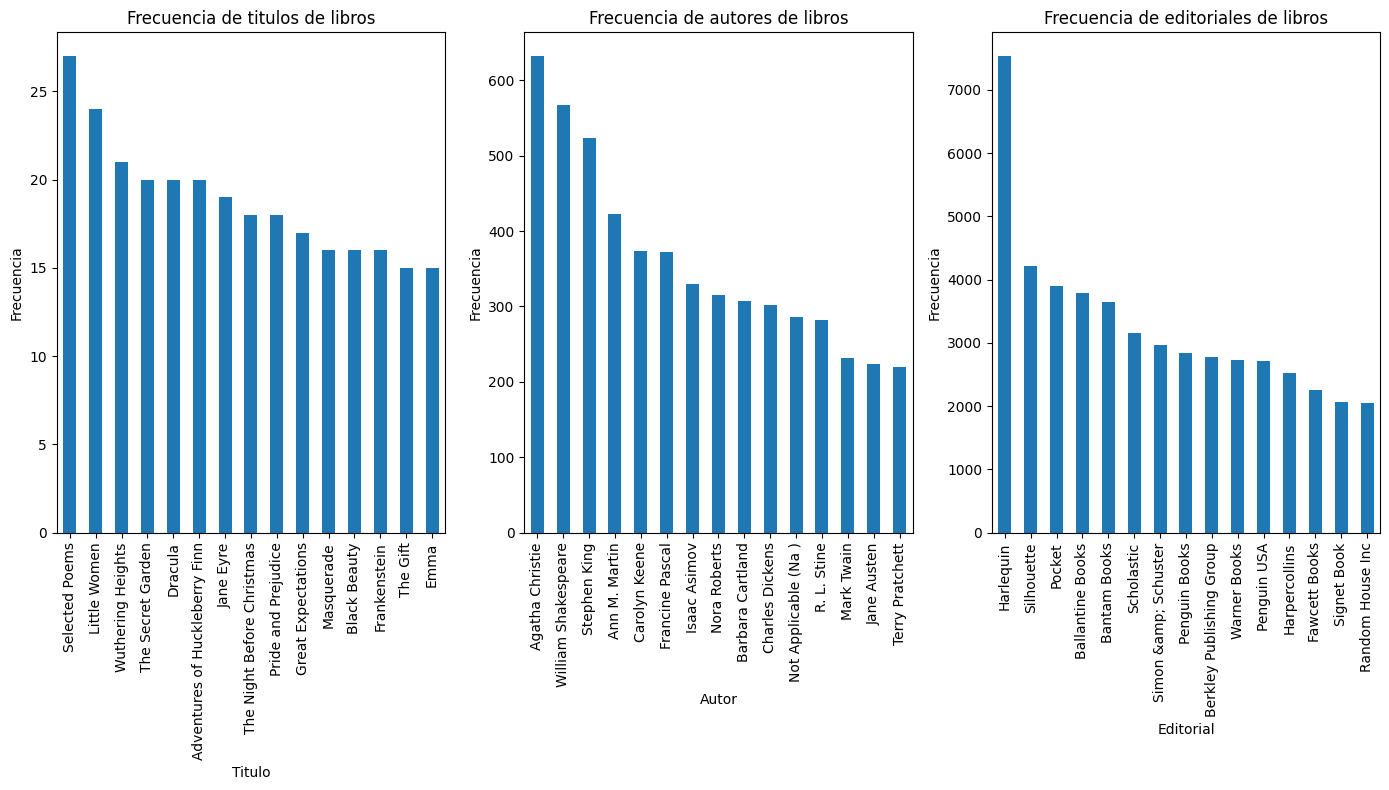

In [38]:
# Visualización de la distribución de las variables de df_users
fig, ax = plt.subplots(1, 3, figsize=(14, 8))

df_books['Book-Title'].value_counts().head(15).plot.bar(ax=ax[0])
ax[0].set_title('Frecuencia de titulos de libros')
ax[0].set_ylabel('Frecuencia')
ax[0].set_xlabel('Titulo')

df_books['Book-Author'].value_counts().head(15).plot.bar(ax=ax[1])
ax[1].set_title('Frecuencia de autores de libros')
ax[1].set_ylabel('Frecuencia')
ax[1].set_xlabel('Autor')

df_books['Publisher'].value_counts().head(15).plot.bar(ax=ax[2])
ax[2].set_title('Frecuencia de editoriales de libros')
ax[2].set_ylabel('Frecuencia')
ax[2].set_xlabel('Editorial')

fig.tight_layout()


**DataFrame Users**

Con relación a los usuarios, se realizó un histograma de la distribución de las edades de los usuarios. Se puede observar que la mayoría de usuarios tienen entre 20 y 40 años.

Nuevamente, cabe destacar la presencia de usuarios con edad 0 y una persona con edad 244 años. Nuevamente, se requiere investigar más sobre estos usuarios.

array([[<AxesSubplot: title={'center': 'User-ID'}>,
        <AxesSubplot: title={'center': 'Age'}>]], dtype=object)

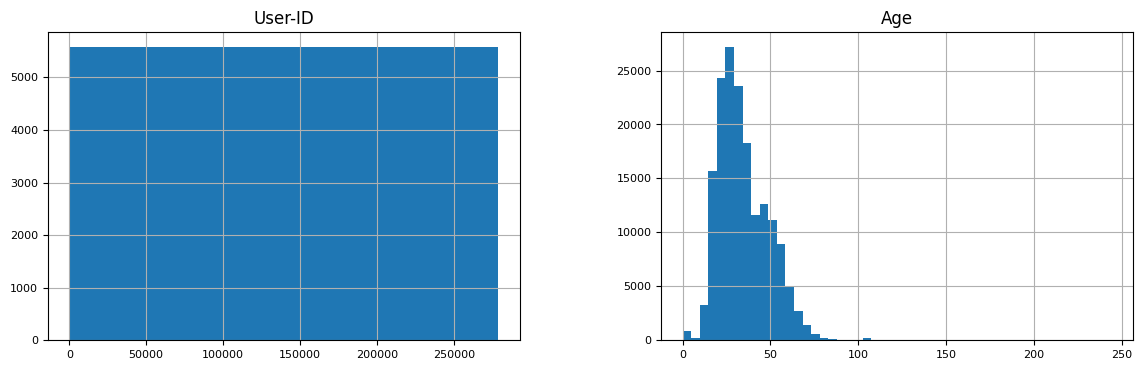

In [31]:
# Visualización de la distribución de las variables de df_users
df_users.hist(figsize=(14, 4), bins=50, xlabelsize=8, ylabelsize=8)

Al analizar la distribución de las ubicaciones de los usuarios, se puede observar que la ciudad con más usuarios es Londres, seguido de Toronto y Sydney. Cabe destacar que, a pesar de que Estados Unidos es el país con más usuarios, no hay ninguna ciudad de Estados Unidos en el top 3 de ciudades con más usuarios.

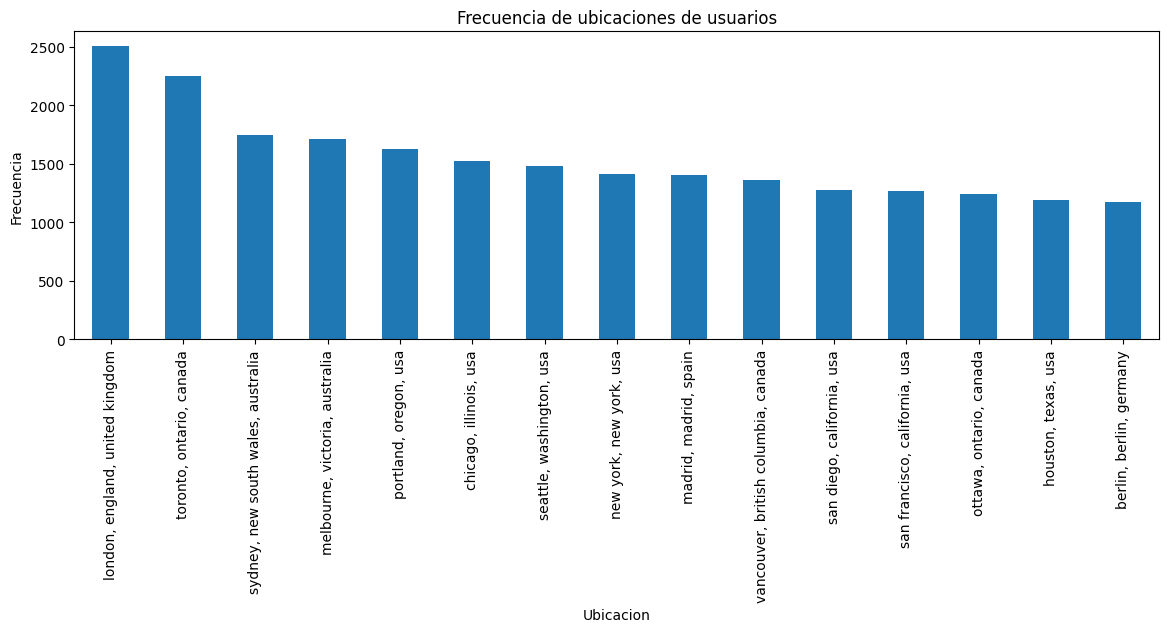

In [34]:
# Visualización de la distribución de las variables de df_users (categorica)

df_users["Location"].value_counts().head(15).plot.bar(figsize=(14, 4))
plt.title("Frecuencia de ubicaciones de usuarios")
plt.xlabel("Ubicacion")
plt.ylabel("Frecuencia")

plt.show()


**DataFrame Raitings**

En el caso de los ratings, se realizó un histograma de la distribución de los ratings. Se puede observar que la mayoría de ratings son 0, seguido de 8 y 10. 

Sin embargo, se considera que los ratings de 0 pueden sesgar el sistema de recomendación, por lo que posiblemente se eliminarán estos ratings. Esto especialmente considerando que la mayoría de ratings son 0; posiblemente más de 60% de los ratings son 0.

array([[<AxesSubplot: title={'center': 'User-ID'}>,
        <AxesSubplot: title={'center': 'ISBN'}>],
       [<AxesSubplot: title={'center': 'Book-Rating'}>, <AxesSubplot: >]],
      dtype=object)

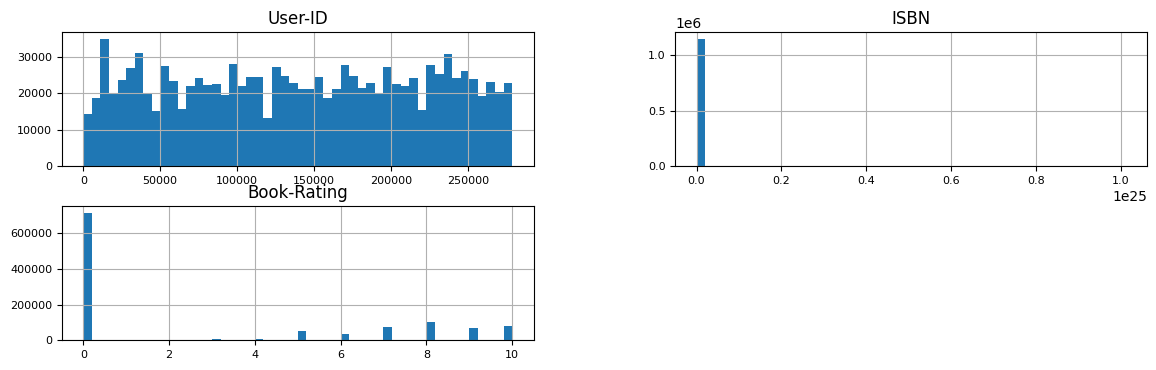

In [39]:
# Visualización de la distribución de las variables de df_ratings
df_ratings.hist(figsize=(14, 4), bins=50, xlabelsize=8, ylabelsize=8)

-----------

##### *Valores Atípicos*

Como cuarto paso, se <font color=orange>identificaron y analizaron los valores atípicos</font> de los conjuntos de datos.

**DataFrame Users**

Inicialmente se pensó que únicamente había un usuario con 244 años. Sin embargo, al analizar el dataframe, se puede observar que hay varios usuarios con más de 100 años. Sin embargo, ninguna persona ha vivido más de 150 años; mucho menos 244 años. Por lo tanto, se considera que estos valores son erróneos.

En la sección de limpieza de datos, se eliminarán estos usuarios.

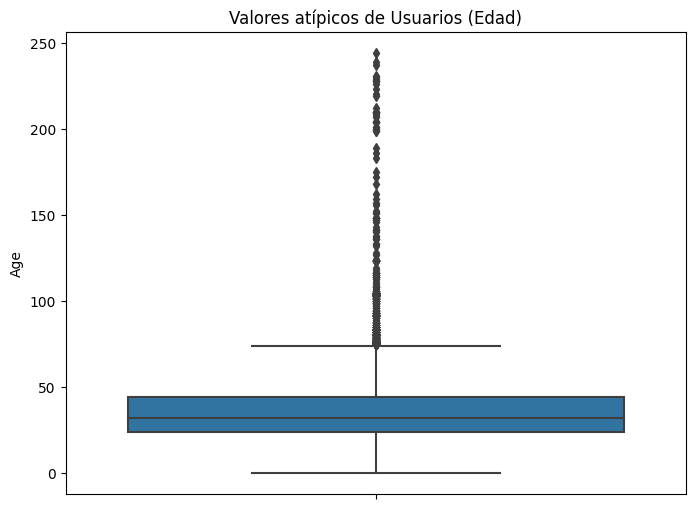

In [40]:
# Valores atípicos de Usuarios (Edad)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_users, y='Age')
plt.title('Valores atípicos de Usuarios (Edad)')
plt.show()

**DataFrame Books**

En el caso de los libros, en las primeras fases del análisis exploratorio de datos, se observó la presencia de uno (o más libros) con año de publicación 0.

Al analizar la distribución de los años de publicación en un gráfico de caja, nuevaente se observa la presencia de libros con año de publicación 0. Asimismo, existen unos libros publicados cerca del año 1400. 


Se considera que los libros del año 0 son erróneos, por lo que se eliminarán en la sección de limpieza de datos. Sin embargo, no se eliminarán los libros del año 1400, ya que es posible que estos libros sean libros antiguos que fueron digitalizados.

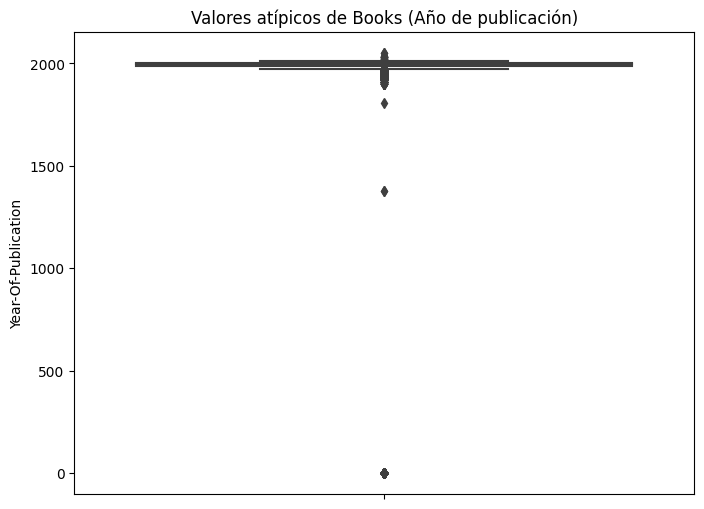

In [41]:
# Valores atípicos de Books (Año de publicación)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_books, y='Year-Of-Publication')
plt.title('Valores atípicos de Books (Año de publicación)')
plt.show()